In [3]:
import os 
import numpy as np

# Compute FSC again 
from locscale.include.emmer.ndimage.fsc_util import calculate_fsc_maps 
from locscale.include.emmer.ndimage.map_utils import save_as_mrc, load_map 
from locscale.include.emmer.pdb.pdb_to_map import pdb2map 
refmac_iterations = np.arange(1, 51)

output_folder_without_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_3061/without_using_averaging/refmac_iteration_50"
model_map_save_loc_without_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_3061/without_using_averaging/modelmaps"
refined_modelmap_per_iteration_without_averaging = {k : os.path.join(output_folder_without_averaging,f"servalcat_refinement_cycle_{k}_no_average.cif") for k in refmac_iterations}

output_folder_with_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_3061/refmac_iteration_50"
model_map_save_loc_with_averaging = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/emd_3061/model_maps/after_average"

halfmap1_path = os.path.join(output_folder_without_averaging, "EMD-3061-half-1.map")
halfmap2_path = os.path.join(output_folder_without_averaging, "EMD-3061-half-2.map")

plot_data_folder = "/home/abharadwaj1/papers/elife_paper/figure_information/data/overfitting_analysis/plot_data"

def compute_fsc_cycle(cycle, halfmap1_path, halfmap2_path,refined_model_map_path):
    #refined_model_cycle = refined_modelmap_per_iteration[cycle]

    assert os.path.exists(refined_model_map_path), f"Refined model map path {refined_model_map_path} does not exist"
    assert os.path.exists(halfmap1_path), f"Halfmap1 path {halfmap1_path} does not exist"
    assert os.path.exists(halfmap2_path), f"Halfmap2 path {halfmap2_path} does not exist"
    
    fsc_vals_halfmap1 = calculate_fsc_maps(refined_model_map_path, halfmap1_path)
    fsc_vals_halfmap2 = calculate_fsc_maps(refined_model_map_path, halfmap2_path)

    fsc_average_halfmap1 = (cycle, np.mean(fsc_vals_halfmap1), fsc_vals_halfmap1)
    fsc_average_halfmap2 = (cycle, np.mean(fsc_vals_halfmap2), fsc_vals_halfmap2)

    results = { 
        "cycle" : cycle,
        "halfmap1" : fsc_average_halfmap1,
        "halfmap2" : fsc_average_halfmap2
    }
    return results


In [5]:
import joblib
# Run the computation in parallel for all the cycles (for the case: without averaging)
n_jobs = 10
verbose = 10
model_map_paths_without_averaging = {k : os.path.join(model_map_save_loc_without_averaging, f"modelmap_cycle_{k}_before_averaging.mrc") for k in refmac_iterations}
results_without_averaging = joblib.Parallel(n_jobs=n_jobs, verbose=10)(joblib.delayed(compute_fsc_cycle)(cycle, halfmap1_path, halfmap2_path, model_map_paths_without_averaging[cycle])\
                                                     for cycle in refmac_iterations)
   


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.5s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.7s
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:   21.9s remaining:    7.7s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:   26.7s remaining:    4.4s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   27.5s finished


In [7]:

# Run the computation in parallel for all the cycles (for the case: with averaging)
model_map_paths_with_averaging = {k : os.path.join(model_map_save_loc_with_averaging, f"modelmap_cycle_{k}_before_averaging.mrc") for k in refmac_iterations}
results_with_averaging = joblib.Parallel(n_jobs=n_jobs, verbose=10)(joblib.delayed(compute_fsc_cycle)(cycle, halfmap1_path, halfmap2_path, model_map_paths_with_averaging[cycle])\
                                                        for cycle in refmac_iterations)


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   5 tasks      | elapsed:    5.8s
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   10.6s
[Parallel(n_jobs=10)]: Done  21 tasks      | elapsed:   15.6s
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:   16.8s
[Parallel(n_jobs=10)]: Done  37 out of  50 | elapsed:   21.0s remaining:    7.4s
[Parallel(n_jobs=10)]: Done  43 out of  50 | elapsed:   25.8s remaining:    4.2s
[Parallel(n_jobs=10)]: Done  50 out of  50 | elapsed:   27.5s finished


In [8]:
fsc_cycles_halfmap1_without_averaging = {}
fsc_cycles_halfmap2_without_averaging = {}
for result in results_without_averaging:
    cycle = result["cycle"]
    fsc_cycles_halfmap1_without_averaging[cycle] = result["halfmap1"]
    fsc_cycles_halfmap2_without_averaging[cycle] = result["halfmap2"]

fsc_cycles_halfmap1_with_averaging = {}
fsc_cycles_halfmap2_with_averaging = {}
for result in results_with_averaging:
    cycle = result["cycle"]
    fsc_cycles_halfmap1_with_averaging[cycle] = result["halfmap1"]
    fsc_cycles_halfmap2_with_averaging[cycle] = result["halfmap2"]


In [22]:
def jsonify_dictionary(input_dict):
    # convert pickle object to json object
    new_dict = {}
    for key, value in input_dict.items():
        key = str(key) 
        value_is_iterable = isinstance(value, (list, tuple, np.ndarray))
        value_is_dict = isinstance(value, dict)
        value_is_float = isinstance(value, float)
        value_is_int = isinstance(value, (np.int64, int, np.int32))
        value_is_string = isinstance(value, str)
        
        print("key: {}, value_is_iterable: {}, value_is_dict: {}, value_is_float: {}, \
              value_is_int: {}, value_is_string: {}".format(key, value_is_iterable, \
                                                            value_is_dict, value_is_float, value_is_int, value_is_string))
        
        if value_is_dict:
            new_value = jsonify_dictionary(value)
        elif value_is_iterable:
            new_value = [str(x) for x in value]
        elif not value_is_string:
            new_value = str(value)
        
        new_dict[key] = new_value
        
    
    return new_dict 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


key: fsc_cycles_halfmap1_without_averaging, value_is_iterable: False, value_is_dict: True, value_is_float: False,               value_is_int: False, value_is_string: False
key: 1, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 2, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 3, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 4, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 5, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 6, value_is_iterable: True, value_is_dict: False, value_is_float: False,               value_is_int: False, value_is_string: False
key: 7, valu

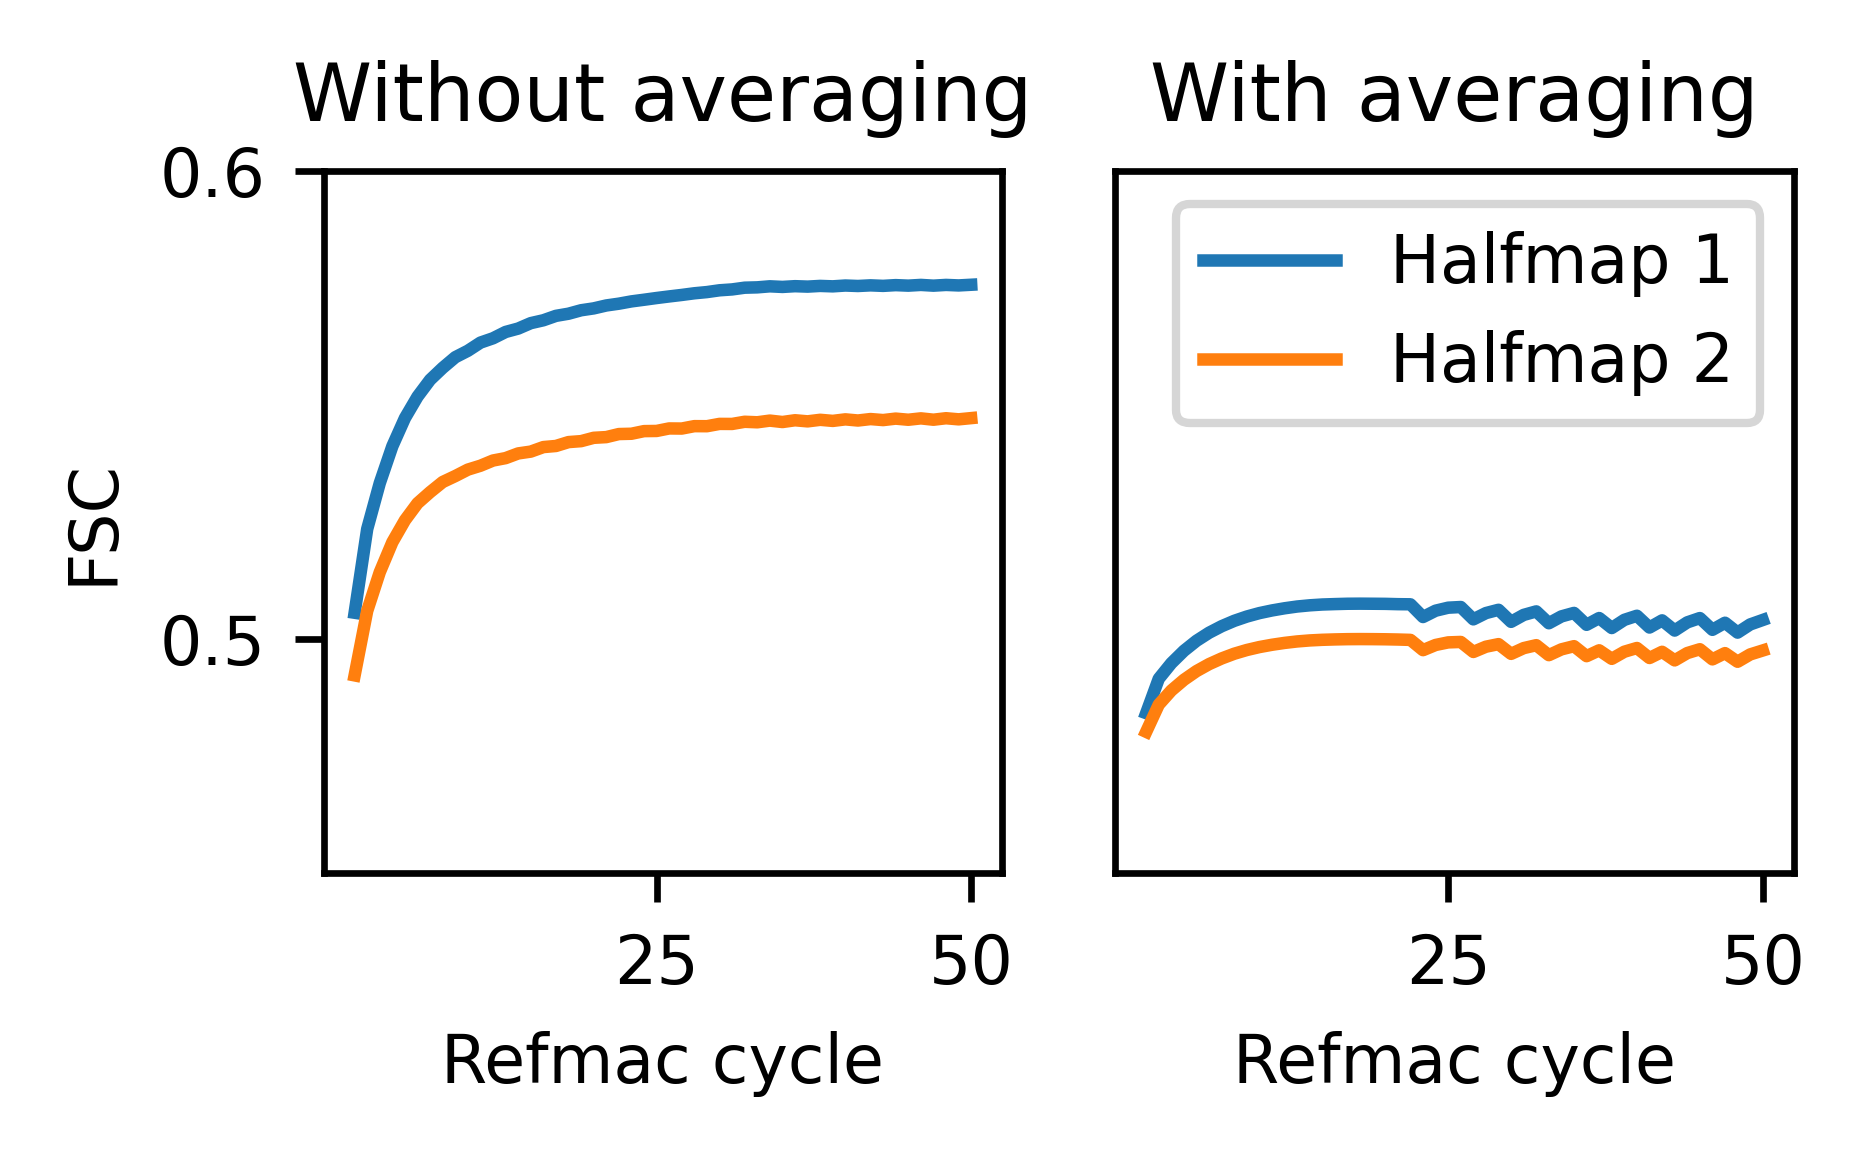

In [26]:
fsc_average_curve_halfmap1_without_averaging = [fsc_cycles_halfmap1_without_averaging[cycle][1] for cycle in refmac_iterations]
fsc_average_curve_halfmap2_without_averaging = [fsc_cycles_halfmap2_without_averaging[cycle][1] for cycle in refmac_iterations]
fsc_average_curve_halfmap1_with_averaging = [fsc_cycles_halfmap1_with_averaging[cycle][1] for cycle in refmac_iterations]
fsc_average_curve_halfmap2_with_averaging = [fsc_cycles_halfmap2_with_averaging[cycle][1] for cycle in refmac_iterations]

import matplotlib.pyplot as plt
figsize_cm = (8,5)
figsize_inch = (figsize_cm[0]/2.54, figsize_cm[1]/2.54)
fig, ax = plt.subplots(1, 2, figsize=figsize_inch, dpi=600)
# set font size to font
fontsize = 8
plt.rcParams.update({'font.size': fontsize})
yticks = [0.5, 0.6]
xticks = [25, 50]
ax[0].plot(refmac_iterations, fsc_average_curve_halfmap1_without_averaging, label="Halfmap 1")
ax[0].plot(refmac_iterations, fsc_average_curve_halfmap2_without_averaging, label="Halfmap 2")
ax[0].set_xlabel("Refmac cycle")
ax[0].set_ylabel("FSC")
ax[0].set_title("Without averaging")
ax[0].set_ylim([0.45, 0.6])
ax[0].set_yticks(yticks, fontsize=fontsize)
ax[0].set_xticks(xticks, fontsize=fontsize)

ax[1].plot(refmac_iterations, fsc_average_curve_halfmap1_with_averaging, label="Halfmap 1")
ax[1].plot(refmac_iterations, fsc_average_curve_halfmap2_with_averaging, label="Halfmap 2")
ax[1].set_xlabel("Refmac cycle")
ax[1].set_ylabel("FSC")
ax[1].set_title("With averaging")
ax[1].set_ylim([0.45, 0.6])
# hide y axis
ax[1].get_yaxis().set_visible(False)
ax[1].set_xticks(xticks, fontsize=fontsize)
ax[1].legend()

plt.tight_layout()

plt.savefig(os.path.join(plot_data_folder, "fsc_curves_with_and_without_averaging.eps"), bbox_inches='tight')

# dump the results into a json file 
import json
results = {
    "fsc_cycles_halfmap1_without_averaging" : fsc_cycles_halfmap1_without_averaging,
    "fsc_cycles_halfmap2_without_averaging" : fsc_cycles_halfmap2_without_averaging,
    "fsc_cycles_halfmap1_with_averaging" : fsc_cycles_halfmap1_with_averaging,
    "fsc_cycles_halfmap2_with_averaging" : fsc_cycles_halfmap2_with_averaging,
    "cycles" : refmac_iterations,
}

with open(os.path.join(plot_data_folder, "fsc_curves_with_and_without_averaging.json"), "w") as f:
    json.dump(jsonify_dictionary(results), f, indent=4)

(0.45, 0.6)

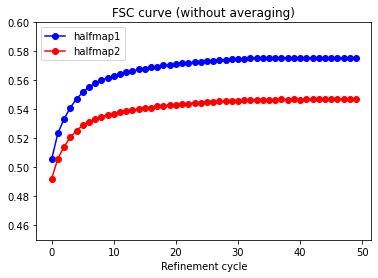

In [5]:
fsc_average_curve_halfmap1 = [fsc_cycles_halfmap1[cycle][1] for cycle in refmac_iterations]
fsc_average_curve_halfmap2 = [fsc_cycles_halfmap2[cycle][1] for cycle in refmac_iterations]
plt.plot(fsc_average_curve_halfmap1, "bo-", label="halfmap1")
plt.plot(fsc_average_curve_halfmap2, "ro-", label="halfmap2")
plt.legend()
plt.title("FSC curve (without averaging)")
plt.xlabel("Refinement cycle")
plt.ylim(0.45, 0.6)

